In [1]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score # Using F1 score
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks
import all_metrics as all_metrics # Assuming your custom metrics function is available
import credit_card_fraud_utils as ccf
import os

import warnings
print("Attempting to ignore ALL UserWarnings via environment variable...")
os.environ["PYTHONWARNINGS"] = 'ignore::UserWarning'


Attempting to ignore ALL UserWarnings via environment variable...


In [2]:
config = ccf.Config()
# Load the dataset
df = ccf.load_data(config)

# Display basic information
print(f"Dataset Shape: {df.shape}")
print(f"Number of Transactions: {df.shape[0]}")
print(f"Number of Features: {df.shape[1]}")

# Display the first few rows
df.head()

Dataset Shape: (284807, 31)
Number of Transactions: 284807
Number of Features: 31


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Class'])
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)



### Random search

In [4]:


# This is the recommended way to handle imbalance directly within XGBoost
neg_count = np.sum(y_train == 0)
pos_count = np.sum(y_train == 1)
# Handle potential division by zero if pos_count is 0 (though unlikely if it's the minority class)
scale_pos_weight_value = 1.0 if pos_count == 0 else neg_count / pos_count
print(f"Target scale_pos_weight for XGBoost: {scale_pos_weight_value:.2f}")
# ---

# 1. Define Pipeline with Scaler and XGBoost Classifier
pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()), # Keep scaler for consistency
    ('resampler', None),          # Placeholder for resampling step
    ('classifier', XGBClassifier(
        random_state=42,
        objective='binary:logistic', # Objective for binary classification
        eval_metric='logloss',       # Common evaluation metric during training
        use_label_encoder=True      # Suppress warning in newer XGBoost versions
    ))
])

# 2. Define Expanded Parameter Grid for XGBoost

# Common XGBoost parameter ranges to explore
xgb_param_ranges = {
    'classifier__n_estimators': [100, 200, 300, 400, 500], # More trees?
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7, 9], # Deeper trees?
    'classifier__subsample': [0.7, 0.8, 0.9, 1.0], # Row sampling
    'classifier__colsample_bytree': [0.7, 0.8, 0.9, 1.0], # Column sampling per tree
    'classifier__gamma': [0, 0.1, 0.5, 1, 2], # Min loss reduction for split
    'classifier__reg_alpha': [0, 0.01, 0.1, 1], # L1 regularization
    'classifier__reg_lambda': [0.1, 1, 5, 10] # L2 regularization (often start > 0)
}

# Expanded resampler parameters
smote_k_neighbors = [3, 5, 10]
adasyn_n_neighbors = [3, 5, 10]
rus_sampling_strategy = [0.2, 0.35, 0.5] # Ratio minority/majority after RUS
ros_sampling_strategy = [0.5, 0.7, 1.0] # Ratio minority/majority after ROS

# List to hold all grid dictionaries
param_grid_xgb = []

# --- Configuration for NO Resampling ---

param_grid_xgb.append({
    'resampler': [None],
    **xgb_param_ranges,
    'classifier__scale_pos_weight': [1, scale_pos_weight_value] # Test default vs calculated weight
})

# --- Configurations for Resampling Methods --
resampling_options_list = [
    {'resampler': [SMOTE(random_state=42)], 'resampler__k_neighbors': smote_k_neighbors},
    {'resampler': [ADASYN(random_state=42)], 'resampler__n_neighbors': adasyn_n_neighbors},
    {'resampler': [RandomOverSampler(random_state=42)], 'resampler__sampling_strategy': ros_sampling_strategy},
    {'resampler': [RandomUnderSampler(random_state=42)], 'resampler__sampling_strategy': rus_sampling_strategy},
    {'resampler': [TomekLinks(sampling_strategy='auto')]},
    {'resampler': [NearMiss(version=1)]}
]

for resampler_config in resampling_options_list:
    config = {
        **resampler_config,
        **xgb_param_ranges,
        'classifier__scale_pos_weight': [1] # Set to 1 (no weight) when resampling
    }
    param_grid_xgb.append(config)

# 3. Configure RandomizedSearchCV
n_iterations_xgb = 75 # Adjust based on time/resources (e.g., 50-150)
scoring_metric = 'f1' # Target F1 score directly
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search_xgb = RandomizedSearchCV(
    pipeline_xgb,
    param_distributions=param_grid_xgb,
    n_iter=n_iterations_xgb,
    scoring=scoring_metric,
    refit=scoring_metric, # Refit the best model based on F1 score
    cv=cv_strategy,
    verbose=0,            # Show detailed progress
    n_jobs=-1,            # Use all CPU cores
    random_state=42
)

# 4. Run the Search
print(f"\nStarting RandomizedSearchCV for XGBoost with n_iter={n_iterations_xgb}...")
print(f"Optimizing for '{scoring_metric}' score.")
print(f"Best Logistic Regression Test F1 was: 0.6951") # Remind ourselves of the target



Target scale_pos_weight for XGBoost: 577.29

Starting RandomizedSearchCV for XGBoost with n_iter=75...
Optimizing for 'f1' score.
Best Logistic Regression Test F1 was: 0.6951


In [5]:

random_search_xgb.fit(X_train, y_train)

# 5. Process Results (After Fitting)
print("\nBest XGBoost Parameters Found:")
print(random_search_xgb.best_params_)
print("\nBest CV " + scoring_metric.upper() + " Score:")
print(random_search_xgb.best_score_)

KeyboardInterrupt: 

In [17]:

print("\n--- Evaluating Best XGBoost Model on Test Set ---")
best_pipeline_xgb = random_search_xgb.best_estimator_
results_xgb = all_metrics.calculate_model_metrics(
    best_pipeline_xgb, X_test, y_test, 'XGBoost (RandomizedSearch Best)'
)



--- Evaluating Best XGBoost Model on Test Set ---

Metrics for XGBoost (RandomizedSearch Best):
Accuracy: 0.9996
Precision: 0.9750
Recall: 0.7959
F1-score: 0.8764
AUPRC: 0.8927
AUROC: 0.9851
Recall at 0.5% FPR: 0.9082
Precision at 0.5% Recall: 1.0000
Matthews Correlation Coefficient: 0.8807
Kolmogorov-Smirnov Statistic: 0.9273
Confusion Matrix:
[[56862     2]
 [   20    78]]


In [6]:
# Import from scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical


# --- Define Pipeline (same as before) ---
pipeline_xgb_bayes = Pipeline([
    ('scaler', StandardScaler()),
    ('resampler', None), # Placeholder, will be fixed in search space
    ('classifier', XGBClassifier(
        random_state=42,
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False # Recommended for newer XGBoost versions
    ))
])

# --- Define Search Space for BayesSearchCV ---
# Focus around the best parameters found previously, but allow exploration
# Previous bests: n_estimators=300, learning_rate=0.05, max_depth=7, subsample=0.9,
#                colsample_bytree=0.9, gamma=0, reg_alpha=0.01, reg_lambda=0.1
search_spaces_bayes = {
    # --- Fixed Parameters ---
    'resampler': Categorical([None]), # Fix based on previous results
    'classifier__scale_pos_weight': Categorical([1]), # Fix based on previous results

    # --- XGBoost Parameters with skopt Ranges ---
    'classifier__n_estimators': Integer(200, 500), # Explore around 300
    'classifier__learning_rate': Real(0.01, 0.15, prior='log-uniform'), # Log scale around 0.05
    'classifier__max_depth': Integer(5, 10), # Explore around 7
    'classifier__subsample': Real(0.7, 1.0, prior='uniform'), # Explore around 0.9
    'classifier__colsample_bytree': Real(0.7, 1.0, prior='uniform'), # Explore around 0.9
    'classifier__gamma': Real(0, 1.0, prior='uniform'), # Explore around 0
    # Log scale often good for regularization terms
    'classifier__reg_alpha': Real(1e-3, 0.5, prior='log-uniform'), # Explore around 0.01
    'classifier__reg_lambda': Real(0.05, 5.0, prior='log-uniform') # Explore around 0.1
}

# --- Configure BayesSearchCV ---
n_iterations_bayes = 50 # Number of parameter settings that are sampled. BayesSearchCV can often find good results faster.
scoring_metric = 'f1'
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

bayes_search_xgb = BayesSearchCV(
    estimator=pipeline_xgb_bayes,
    search_spaces=search_spaces_bayes,
    n_iter=n_iterations_bayes,
    scoring=scoring_metric,
    cv=cv_strategy,
    n_jobs=-1,            # Use all available CPU cores
    refit=True,           # Refit the best estimator found on the whole dataset
    random_state=42,      # For reproducibility
    verbose=1             # Show progress
)

In [7]:
print(f"\nStarting BayesSearchCV for XGBoost with n_iter={n_iterations_bayes}...")
print(f"Optimizing for '{scoring_metric}' score.")
print(f"Using focused search space around previous best results (Resampler=None, scale_pos_weight=1).")

# Fit the BayesSearchCV object
# Ensure X_train and y_train are available
bayes_search_xgb.fit(X_train, y_train) 


Starting BayesSearchCV for XGBoost with n_iter=50...
Optimizing for 'f1' score.
Using focused search space around previous best results (Resampler=None, scale_pos_weight=1).
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                        ('resampler', None),
                                        ('classifier',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,...
                             'classifier__reg_alpha': Real(low=0.001, high=0.5, prior='log-uniform', transform='normalize'),
                             'classifier__reg_lambda': Real(low=0.05, high=5.0, prior='log-uniform', transform='normalize'),
                             'classifier__scale_pos_weight': Categorical(categories=(1,), prior=None),
                             'classifier__subsample': Real(low=0.7, high=1.0, prior='uniform', transform='normalize'),
                             'resampler': Categorical(categories=(None,), prior=None)},
              verbose=1)

In [8]:
print("\nBest XGBoost Parameters Found (BayesSearchCV):")
print(bayes_search_xgb.best_params_) # Note: .best_params_ gives a dictionary, values might be numpy types
# Convert to standard types if needed for printing/saving:
best_params_dict = dict(bayes_search_xgb.best_params_)
print(best_params_dict)


Best XGBoost Parameters Found (BayesSearchCV):
OrderedDict([('classifier__colsample_bytree', 0.939866032482152), ('classifier__gamma', 0.43802918644092337), ('classifier__learning_rate', 0.041624924398728134), ('classifier__max_depth', 9), ('classifier__n_estimators', 471), ('classifier__reg_alpha', 0.08614807334958828), ('classifier__reg_lambda', 0.35263559617083484), ('classifier__scale_pos_weight', 1), ('classifier__subsample', 0.8059251536583913), ('resampler', None)])
{'classifier__colsample_bytree': 0.939866032482152, 'classifier__gamma': 0.43802918644092337, 'classifier__learning_rate': 0.041624924398728134, 'classifier__max_depth': 9, 'classifier__n_estimators': 471, 'classifier__reg_alpha': 0.08614807334958828, 'classifier__reg_lambda': 0.35263559617083484, 'classifier__scale_pos_weight': 1, 'classifier__subsample': 0.8059251536583913, 'resampler': None}


In [9]:
print("\n--- Evaluating Best XGBoost Model on Test Set ---")
best_pipeline_xgb_bayes = bayes_search_xgb.best_estimator_
results_xgb_bayes = all_metrics.calculate_model_metrics(
    best_pipeline_xgb_bayes, X_test, y_test, 'XGBoost (RandomizedSearch Best)'
)



--- Evaluating Best XGBoost Model on Test Set ---

Metrics for XGBoost (RandomizedSearch Best):
Accuracy: 0.9996
Precision: 0.9875
Recall: 0.8061
F1-score: 0.8876
AUPRC: 0.8890
AUROC: 0.9860
Recall at 0.5% FPR: 0.8980
Precision at 0.5% Recall: 1.0000
Matthews Correlation Coefficient: 0.8921
Kolmogorov-Smirnov Statistic: 0.9199
Confusion Matrix:
[[56863     1]
 [   19    79]]


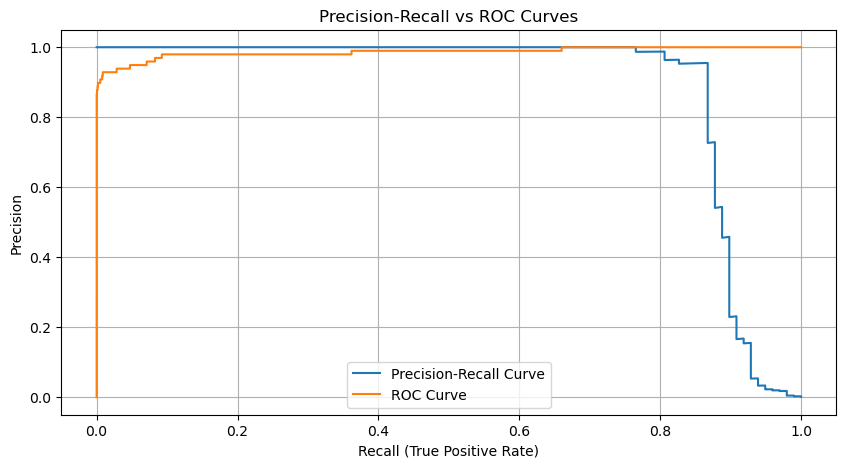

In [10]:
from sklearn.metrics import precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

# Get anomaly scores (the lower the score, the more likely it's an outlier)
y_scores_xgb = bayes_search_xgb.predict_proba(X_test)[:, 1]  # Probability of positive class

# Get binary predictions for metrics
y_pred_xgb = bayes_search_xgb.predict(X_test)

# Calculate precision-recall curve
precision_xgb, recall_xgb, thresholds_pr = precision_recall_curve(y_test, y_scores_xgb)

# Calculate ROC curve
fpr_xgb, tpr_xgb, thresholds_roc = roc_curve(y_test, y_scores_xgb)

# Plot both curves
plt.figure(figsize=(10, 5))
plt.plot(recall_xgb, precision_xgb, label='Precision-Recall Curve')
plt.plot(fpr_xgb, tpr_xgb, label='ROC Curve')
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision')
plt.title('Precision-Recall vs ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

### Refined Grid search

We have pretty good performance already, lets try to refine it using gridsearch.

In [20]:
from sklearn.model_selection import GridSearchCV



# --- Refined Parameter Grid ---
param_grid_xgb_refined = {
    # --- Fixed Parameters based on RandomizedSearch results ---
    'resampler': [None],
    'classifier__scale_pos_weight': [1], # Fixing based on previous best result

    # --- Focused XGBoost Parameters ---
    # Center ranges around the previous best values
    'classifier__n_estimators': [250, 300, 350],       # Around 300
    'classifier__learning_rate': [0.04, 0.05, 0.06],    # Around 0.05
    'classifier__max_depth': [6, 7, 8],                 # Around 7
    'classifier__subsample': [0.85, 0.9, 0.95],         # Around 0.9
    'classifier__colsample_bytree': [0.85, 0.9, 0.95],  # Around 0.9
    'classifier__gamma': [0, 0.05, 0.1],                # Around 0
    'classifier__reg_alpha': [0, 0.01, 0.05],           # Around 0.01
    'classifier__reg_lambda': [0.05, 0.1, 0.2]          # Around 0.1
}

# Calculate number of combinations (be mindful of computational cost)
num_combinations = 1 * 1 * 3 * 3 * 3 * 3 * 3 * 3 * 3 * 3 # = 3^8 = 6561
print(f"Refined GridSearchCV will test {num_combinations} combinations.")

# --- Configure GridSearchCV ---

cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring_metric = 'f1'

grid_search_xgb = GridSearchCV(
    pipeline_xgb,
    param_grid=param_grid_xgb_refined, # Note: param_grid, not param_distributions
    scoring=scoring_metric,
    refit=scoring_metric,
    cv=cv_strategy,
    verbose=1, # Increase verbosity to see progress
    n_jobs=-1
)



Refined GridSearchCV will test 6561 combinations.


In [ ]:
# --- Run the Grid Search ---
print("\nStarting GridSearchCV for XGBoost...")
grid_search_xgb.fit(X_train, y_train) #




Starting GridSearchCV for XGBoost...
Fitting 3 folds for each of 6561 candidates, totalling 19683 fits


KeyboardInterrupt: 

In [ ]:
# --- Process Results (After Fitting) ---
print("\nBest XGBoost Parameters Found (GridSearch):")
print(grid_search_xgb.best_params_)
print("\nBest CV " + scoring_metric.upper() + " Score (GridSearch):")
print(grid_search_xgb.best_score_)



In [ ]:
# --- Evaluate on Test Set ---
print("\n--- Evaluating Best XGBoost Model from GridSearch on Test Set ---")
best_pipeline_xgb_grid = grid_search_xgb.best_estimator_
results_xgb_grid = all_metrics.calculate_model_metrics(
     best_pipeline_xgb_grid, X_test, y_test, 'XGBoost (GridSearch Best)'
)